# Only RandomForest

In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tdc.single_pred import Tox
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import explained_variance_score, max_error, \
                     mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = Tox(name='LD50_Zhu').get_data()

Found local copy...
Loading...
Done!


In [3]:
data

,Drug_ID,Drug,Y
0,"Diazene, diphenyl-, 1-oxide",[O-][N+](=Nc1ccccc1)c1ccccc1,2.505
1,"Methane, tribromo-",BrC(Br)Br,2.343
2,Bromoethene (9CI),C=CBr,2.330
3,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
4,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
...,...,...,...
7380,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427
7381,"1,3-Benzenediamine, 4-(1,1,2,2-tetrafluoroetho...",Nc1ccc(OC(F)(F)C(F)F)c(N)c1,2.321
7382,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050
7383,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


In [4]:
PandasTools.AddMoleculeColumnToFrame(data,'Drug','Molecule')
if data.Molecule.isna().sum() == 0:
    print('Smiles loaded')

Smiles loaded


,Drug_ID,Drug,Y,Molecule
130,"7-Oxabicyclo(4.1.0)hepta-2,4,6-triene, 3-oxira...",c1cc2c(cc1C1CO1)O2,1.676,
2199,"Urea, 1-methyl-1-nitroso- (8CI)",CN(N=O)C(N)=O,2.972,
635,"Benzenesulfonic acid, 2-amino-4-chloro-5-methyl-",Cc1cc(S(=O)(=O)O)c(N)cc1Cl,1.256,

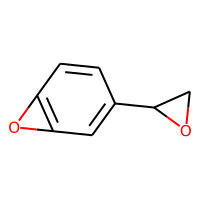
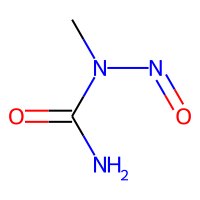
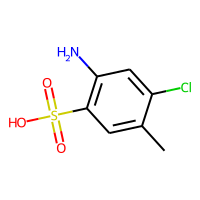

In [5]:
data.sample(3)

## The descriptors didn't improve the accuracy, so I removed them

In [6]:
def MorganFP(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    #fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    """
    d = [
        Descriptors.MolLogP(mol),
        Descriptors.MolMR(mol), 
        Descriptors.MolWt(mol),
        Descriptors.ExactMolWt(mol),
        Descriptors.BalabanJ(mol), 
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumValenceElectrons(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.HeavyAtomMolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.FpDensityMorgan1(mol),
        Descriptors.FpDensityMorgan2(mol),
        Descriptors.FpDensityMorgan3(mol),
        Descriptors.MaxAbsPartialCharge(mol),
        Descriptors.MaxPartialCharge(mol),
        Descriptors.MinAbsPartialCharge(mol),
        Descriptors.MinPartialCharge(mol),
        Descriptors.NumRadicalElectrons(mol),
        Descriptors.NumValenceElectrons(mol),
        rdMolDescriptors.CalcChi0n(mol),
        rdMolDescriptors.CalcChi0v(mol),
        rdMolDescriptors.CalcChi1n(mol),
        rdMolDescriptors.CalcChi1v(mol),
        rdMolDescriptors.CalcChi2n(mol),
        rdMolDescriptors.CalcChi2v(mol),
        rdMolDescriptors.CalcChi3n(mol),
        rdMolDescriptors.CalcChi3v(mol),
        rdMolDescriptors.CalcChi4n(mol),
        rdMolDescriptors.CalcChi4v(mol),
        rdMolDescriptors.CalcKappa1(mol),
        rdMolDescriptors.CalcKappa2(mol),
        rdMolDescriptors.CalcKappa3(mol),
        rdMolDescriptors.CalcLabuteASA(mol),
        # and others https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
        ]
    ar2 = np.asarray(d, dtype=np.float32)
    #ar2 = np.array(d)
    return np.concatenate((ar, ar2))
    """
    return ar

In [7]:
data["Morgan_FP"] = data.Molecule.apply(MorganFP)

,Drug_ID,Drug,Y,Molecule,Morgan_FP
105,Cyclohexane,C1CCCCC1,0.821,,"[0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

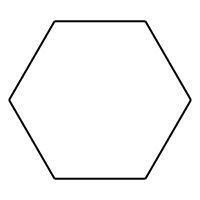

In [8]:
data.sample(1)

In [9]:
X = np.stack(data.Morgan_FP.values)
print(X.shape)

(7385, 4096)


In [10]:
y = data.Y.values.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)

In [11]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
from sklearn.feature_selection import VarianceThreshold
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_test = feature_select.transform(X_test)
X_train.shape

(6646, 159)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

regr = RandomForestRegressor()
parameters = {'n_estimators' : range(10,50),
              'max_depth' : range(3,200), 'min_samples_split' : range(3,20)}
randomized_search_model = RandomizedSearchCV(regr, parameters, n_iter=20, cv=5, verbose=1, scoring='neg_mean_squared_error')

In [16]:
randomized_search_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': range(3, 200),
                                        'min_samples_split': range(3, 20),
                                        'n_estimators': range(10, 50)},
                   scoring='neg_mean_squared_error', verbose=1)

In [17]:
pd.DataFrame(randomized_search_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.831263,0.148182,0.012391,0.002654,27,10,140,"{'n_estimators': 27, 'min_samples_split': 10, ...",-0.435984,-0.436124,-0.487124,-0.459650,-0.390103,-0.441797,0.031973,10
1,4.417390,0.135272,0.019228,0.003728,41,3,66,"{'n_estimators': 41, 'min_samples_split': 3, '...",-0.421876,-0.423860,-0.459842,-0.449940,-0.369890,-0.425082,0.031254,1
2,2.850404,0.264868,0.011036,0.000883,28,6,187,"{'n_estimators': 28, 'min_samples_split': 6, '...",-0.426420,-0.415018,-0.474139,-0.457653,-0.383830,-0.431412,0.031850,3
3,2.010080,0.026431,0.008793,0.000749,24,18,141,"{'n_estimators': 24, 'min_samples_split': 18, ...",-0.452528,-0.439674,-0.491387,-0.466105,-0.407199,-0.451379,0.027956,15
4,1.990496,0.078241,0.009992,0.002755,19,14,115,"{'n_estimators': 19, 'min_samples_split': 14, ...",-0.459104,-0.448341,-0.487461,-0.470441,-0.399181,-0.452906,0.029823,16
5,2.073225,0.298475,0.013989,0.011583,17,7,103,"{'n_estimators': 17, 'min_samples_split': 7, '...",-0.427180,-0.432494,-0.500984,-0.472525,-0.405190,-0.447675,0.034394,12
6,3.567746,0.204688,0.013789,0.000399,44,15,129,"{'n_estimators': 44, 'min_samples_split': 15, ...",-0.446370,-0.437127,-0.481363,-0.453483,-0.390376,-0.441744,0.029627,9
7,2.647134,0.099347,0.011590,0.000490,34,17,36,"{'n_estimators': 34, 'min_samples_split': 17, ...",-0.447764,-0.439284,-0.484669,-0.468440,-0.400465,-0.448124,0.028628,13
8,1.623611,0.077009,0.007393,0.001355,19,14,157,"{'n_estimators': 19, 'min_samples_split': 14, ...",-0.452174,-0.446269,-0.492171,-0.478974,-0.399717,-0.453861,0.031907,18
9,3.873357,0.359616,0.016188,0.003485,41,7,112,"{'n_estimators': 41, 'min_samples_split': 7, '...",-0.427980,-0.422544,-0.470039,-0.445212,-0.394169,-0.431989,0.025133,5


In [18]:
model = randomized_search_model.best_estimator_

In [20]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [21]:
y_true = y_test
y_pred = y_pred_test

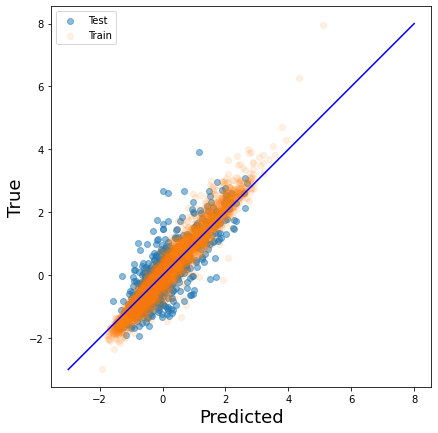

In [22]:
plt.scatter(y_pred_test, y_test, alpha=0.5, label="Test")
plt.scatter(y_pred_train, y_train, alpha=0.1, label="Train")
plt.legend()
plt.plot([-3, 8], [-3,8], c="b")
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.axis('square')
fig = plt.gcf()
fig.set_size_inches(7, 7)

In [24]:
n = 156
X_test[n]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0,
       4, 0, 0, 0, 0], dtype=int8)

In [25]:
y_test[n]

array([1.28553456])

In [26]:
model.predict(X_test[n].reshape(1, -1))

array([1.56057802])

# Model assessment

In [27]:
def assess_model(y_true, y_pred, X_train, y_train):

    def calc_metrics(y_pred):
        score1 = max_error(y_true, y_pred)
        score2 = mean_absolute_error(y_true, y_pred)
        score3 = mean_squared_error(y_true, y_pred)
        score4 = explained_variance_score(y_true, y_pred)
        score5 = r2_score(y_true, y_pred)
        return score1,score2,score3,score4,score5

    dummy1 = DummyRegressor(strategy="mean")
    dummy1.fit(X_train, y_train)
    dummy_mean = dummy1.predict(X_test)

    dummy2 = DummyRegressor(strategy="median")
    dummy2.fit(X_train, y_train)
    dummy_median = dummy2.predict(X_test)

    dummy3 = DummyRegressor(strategy="quantile", quantile=0.0)
    dummy3.fit(X_train, y_train)
    dummy_quantile00 = dummy3.predict(X_test)

    dummy4 = DummyRegressor(strategy="quantile", quantile=0.5)
    dummy4.fit(X_train, y_train)
    dummy_quantile05 = dummy4.predict(X_test)

    dummy5 = DummyRegressor(strategy="quantile", quantile=1.0)
    dummy5.fit(X_train, y_train)
    dummy_quantile10 = dummy5.predict(X_test)
    
    results = [
        calc_metrics(y_pred),
        calc_metrics(dummy_mean),
        calc_metrics(dummy_median),
        calc_metrics(dummy_quantile00),
        calc_metrics(dummy_quantile05),
        calc_metrics(dummy_quantile10)
    ]

    df = pd.DataFrame(results).T 

    df.columns = ['Model', 'dummy(Mean)', 'dummy(Median)', 
                  'dummy(Min Quantile)', 'dummy(Median Quantile)', 
                  'dummy(Max Quantile)']

    df = df.rename(index={0: "max error", 1: "MAE", 2: "MSE", 3:"explained", 4:"r2"})
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    df = df.T

    def highlight_max(data, color='lightgreen'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]

    def highlight_min(data, color='lightgreen'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  
            is_min = data == data.min()
            return [attr if v else '' for v in is_min]


    return df.style.apply(highlight_min, subset=['max error', 'MAE', 'MSE']).\
             apply(highlight_max, subset=['explained', 'r2'])

In [28]:
print("\n"+"Random Forest()")
assess_model(y_true, y_pred, X_train, y_train)


Random Forest()


,max error,MAE,MSE,explained,r2
Model,2.777987,0.422877,0.327686,0.629613,0.629265
dummy(Mean),3.924159,0.742618,0.885747,0.000000,-0.002110
dummy(Median),4.106774,0.718489,0.903324,0.000000,-0.021996
dummy(Min Quantile),6.923277,2.955937,9.621446,0.000000,-9.885441
dummy(Median Quantile),4.106774,0.718489,0.903324,0.000000,-0.021996
dummy(Max Quantile),9.869948,7.986470,64.667592,0.000000,-72.163151


# Random Forest not only surpassed dummy models, but also outperformed LSTM and FeedForward+Descriptors